# Unsupervised Learning with Aerial Imagery and Historic Assay Data

### In Data Science, unsupervised classification is a form of Machine Learning where the data has no known labels or target variable. The idea of unsupervised learning is to find patterns within the data and group similar instances. This notebook looks at the applications of unsupervised learning in geoscience with two examples, incorporating the most common unsupervised learning algorithms; K-means and Hierarchical clustering. The first example looks at grouping pixels of an aerial image based on colour, and the second example looks at discriminating mafic dyke intrusions based upon geochemical data.

<img src="Images/PythonBeach.png" />

### EXAMPLE 1 - K-Means Clustering at Greenly Beach

With my last two notebooks on geological machine learning set in remote Australia, I think it's time for a trip to the beach. This first example is looking at an Landsat image of the Greenly Beach area located on the Eyre Peninsula, South Australia (pictured above). From the aerial photograph (pictured below) we will use an unsupervised learning technique called K-Means Clustering to determine the most dominant pixel values (colours) within the image.

In [K-Means Clustering](https://towardsdatascience.com/understanding-k-means-clustering-in-machine-learning-6a6e67336aa1), the user defines a value K that represents the number of 'centroids', forming the centre of a cluster. This technique is common in unsupervised learning because it is very fast and simple. However, some issues with it are that:

   - It can be hard to find right number of K
   - There is a strong impact of initial seeds on clustering
   - There is a bias towards equal size clusters

Let's look at using K-Means clustering by loading up some python libraries and reading the image.

In [1]:
#Importing libraries and looking at first data frame
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns

#Setting global figure size for the seaborn package
sns.set(rc={'figure.figsize':(15,9)})

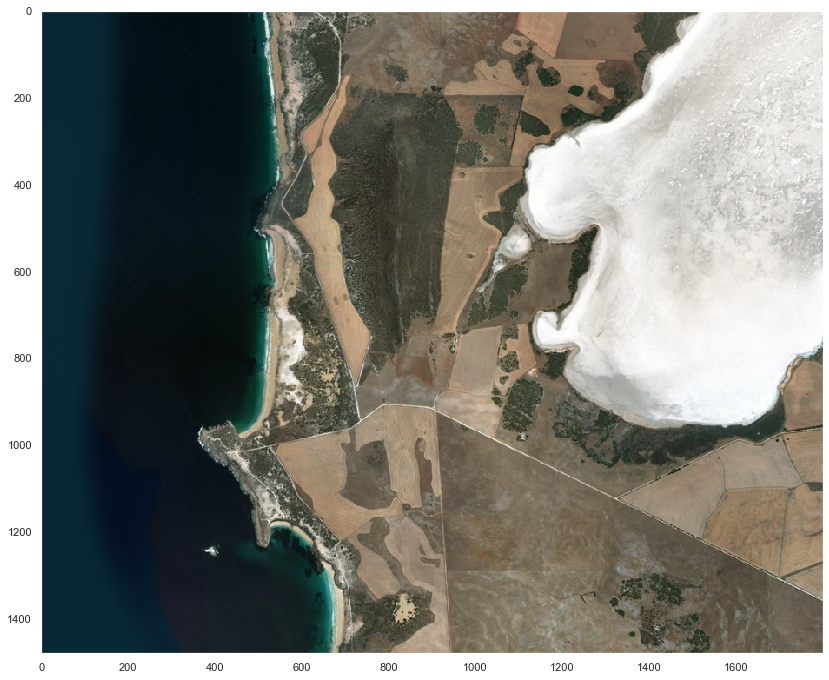

In [2]:
#Reading and viewing the image in the notebook as a numpy array
gb = img.imread('IMAGE PATH')

plt.figure(figsize = (14,18))
plt.grid(None)

plt.imshow(gb)

In [3]:
#Assessing the shape of the array
gb.shape

(1480, 1800, 3)

Noticeably, this image shows 3 main features that could be potentially clustered together. These are the ocean, the crops/shrub area and the dried up Greenly Salt Lake. The shape of the array reflects a 3 band image (red, green and blue channels) of size 1480x1800 pixels. The next step is to split the colour channels into their respective lists and create a pandas DataFrame from it. 

In [4]:
#Setting empty lists for the columns
r = []
g = []
b = []

#Appending pixels to empty lists
for row in gb:
    for pixel in row:
        #A pixel contains RGB values
        temp_r, temp_g, temp_b = pixel
        r.append(temp_r)
        g.append(temp_g)
        b.append(temp_b)

In [5]:
#Converting pixels into a dataframe
pixels = pd.DataFrame({'Red': r,
                       'Green': g,
                       'Blue':b})

pixels.head()

,Red,Green,Blue
0,9,39,50
1,9,39,50
2,9,39,50
3,9,39,50
4,9,39,50


The DataFrame 'pixels' contains the 3 colour values of each pixel from range 0-255. For the clustering operation we will use the python [SciPy](https://www.scipy.org/) package. Using SciPy we will first scale the pixel values with the [whiten](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.whiten.html) function, which scales on a per-feature basis.

In [6]:
from scipy.cluster.vq import whiten

#Scaling the dataframe 
scaled = pd.DataFrame(whiten(pixels), columns=pixels.columns)

scaled.head()

,Red,Green,Blue
0,0.112368,0.541394,0.72744
1,0.112368,0.541394,0.72744
2,0.112368,0.541394,0.72744
3,0.112368,0.541394,0.72744
4,0.112368,0.541394,0.72744


One of the issues mentioned previously is that it can be hard to figure out how many centroids (K) to set in our model. To help with this we will create an elbow plot. The elbow plot looks at the distortion between data and the number of possible clusters. More on that explained [here](https://bl.ocks.org/rpgove/0060ff3b656618e9136b), and other methods of defining clusters can be seen [here](https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/).

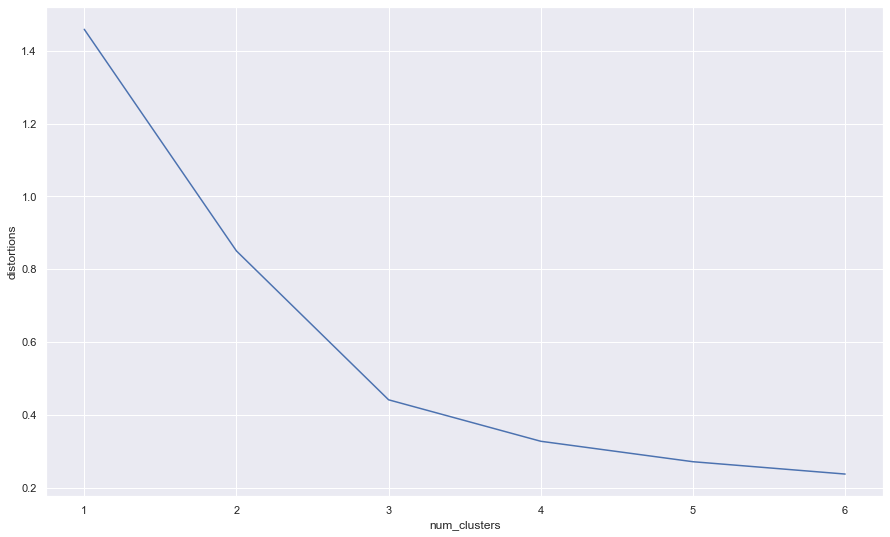

In [29]:
#Showing an elbow plot of how many clusters there could be
from scipy.cluster.vq import kmeans, vq

#Setting an empty list of distortions and a range of clusters to try
distortions = []
num_clusters = range(1, 7)

# Create a list of distortions from the kmeans function
for i in num_clusters:
    cluster_centers, distortion = kmeans(scaled, i)
    distortions.append(distortion)

# Create a data frame with two lists, num_clusters and distortions
elbow_plot = pd.DataFrame({'num_clusters': num_clusters, 'distortions': distortions})

# Create a line plot of num_clusters and distortions
sns.lineplot(x='num_clusters', y='distortions', data = elbow_plot)
plt.xticks(num_clusters)
plt.rcParams['figure.figsize']=(15,9)
plt.show()

From the elbow plot we can see a definitive break at num_clusters=3. This makes sense as we mentioned the three main elements of the image as being the ocean, the crops/shrub area and the dried up Greenly Salt Lake. In the next step we cluster the data to K=3, assign each pixel a cluster label and view the image if all pixels were clustered. This is done by using the SciPy 'vq' function.

In [8]:
#Select 3 clusters as the ones we want to the model
cluster_centers, distortion = kmeans(scaled, 3)

# Assign cluster labels
cluster_labels, distortions = vq(scaled, cluster_centers)

In [9]:
#Reshaping the cluster labels into a 2D array for visualisation
clus_img = cluster_labels.reshape(1480, 1800)

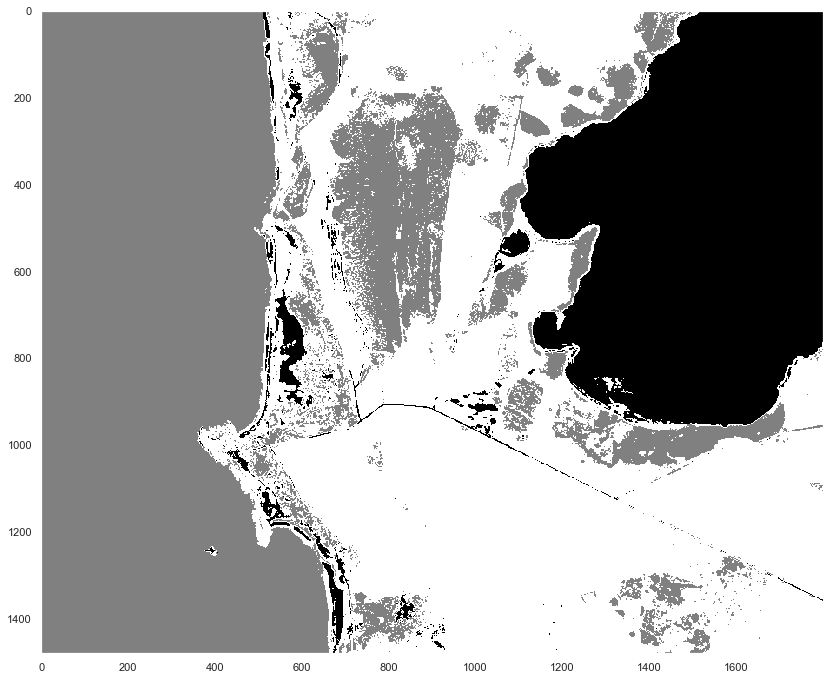

In [10]:
#Returning image
plt.figure(figsize = (14,18))
plt.grid(None)

plt.imshow(clus_img, cmap='gray')
plt.show()

In the clustered pixel image we can see that the three clusters match our visual prediction pretty well. However, some of the grey pixels on the land are clustered together with the ocean pixel values meaning there is some error in our clustering. Keep in mind that this is only using data from three image bands (features) so we should expect some error. In the next step we define what the 3 most dominant colours of the original image are. We do this by firstly converting the cluster centre colour values back to 0-255 range.

In [11]:
#creating an empty list to append to
colors=[]

# Get standard deviations of each color
r_std, g_std, b_std = pixels[['Red', 'Green', 'Blue']].std()

for cluster_center in cluster_centers:
    scaled_r, scaled_g, scaled_b = cluster_center
    # Convert each standardized value to scaled value
    colors.append((
        scaled_r * r_std / 255,
        scaled_g * g_std / 255,
        scaled_b * b_std / 255
    ))

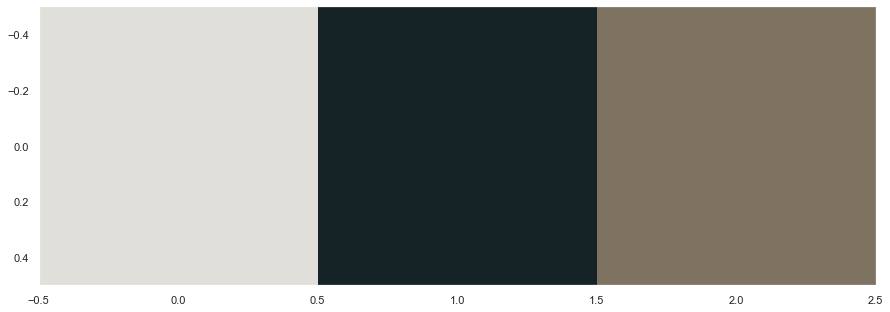

In [12]:
# Display colors of cluster centers
plt.imshow([colors])
plt.grid(None)
plt.show()

The 3 dominant colours shown here reflect what colour each of the 3 centroids have, representing the lake, the ocean and the crops respectively. This is an example of how Aerial Image Clustering can be used to find areas that have similar spectral properties. For more detailed clustering, it would make sense to incorporate hyperspectral imagery data, which contain many more bands and therefore features. A possible application of this in mineral exploration could be to cluster hyperspectral outcrop imagery of a greenfield exploration area for a quick pass lithological map.

<img src="Images/Clustered.png" />

### EXAMPLE 2 - Hierarchical Clustering with Historical Assay Data

The second example in this notebook looks at revisiting and reconstructing a sub-par scientific study done a few years ago. A component of this study was to discriminate (cluster) various mafic dyke intrusions within the Eastern Succession of the Mount Isa Block, Australia. The dykes were clustered based upon mineralogy, geochemistry and geochronology to determine if there are a more prospectable set of intrusions with respect to IOCG mineralisation. The study concluded that there were no 'set' intrusion events of dykes (*yawn*), rather that the dykes were continually emplaced within the Mount Isa Block from the same source of melt. That study of course, is my honours thesis from the University of Adelaide in 2016.

<img src="Images/JMThesis.png" />

In my thesis I plotted many geochemical discrimination diagrams to determine tectonic implications and relationships from assayed dolerite samples. From these plots, I also attempted to manually cluster the samples based upon their geochemical values. In this example we will also cluster samples based upon their geochemical properties, except for this time I will utilise the power of unsupervised hierarchical clustering. 

In [Hierarchical Clustering](https://www.displayr.com/what-is-hierarchical-clustering/), the distance between each sample is calculated and, treating each data point as a cluster, slowly combines data points based upon their distance. One issue with hierarchical clustering is that it does not handle large datasets very well, so thankfully our assay data is quite small in size.

In python, there is a two step process to getting clusters. Firstly, compute a distance matrix and secondly, cluster based upon that distance matrix. These steps are done with the SciPy functions 'Linkage' and 'FCluster' respectively. Before we get to that let's load up the assay data.

In [13]:
#Loading in the assay data and reviewing the head
df = pd.read_csv('ASSAY PATH')

df.head()

,SAMPLE,TYPE,Al,As,Ba,Bi,Ca,Ce,Co,Cr,...,Er,Eu,Tb,Gd,Ho,Lu,Nd,Pr,Sm,Yb
0,RA87176,ROCK,6.47,8.7,110.0,0.12,3.10,47.10,58.1,22,...,4.90,2.11,1.21,6.85,1.64,0.59,23.9,5.85,5.81,4.28
1,RA87177,ROCK,6.69,6.1,300.0,0.10,7.22,16.30,43.4,37,...,2.18,0.95,0.58,3.14,0.76,0.28,9.5,2.11,2.62,1.89
2,RA87178,ROCK,7.31,3.5,150.0,0.11,7.24,20.30,50.2,142,...,2.23,0.99,0.62,3.24,0.74,0.28,11.5,2.65,3.02,2.09
3,RA87179,ROCK,8.57,1.5,60.0,0.04,9.01,5.05,47.5,247,...,1.12,0.51,0.27,1.46,0.35,0.12,3.7,0.71,1.07,0.84
4,RA87180,ROCK,7.06,7.7,240.0,0.55,7.40,12.10,53.0,114,...,2.27,0.95,0.54,2.93,0.74,0.29,7.4,1.57,2.35,1.89


In [14]:
#Splitting the df into categories and variables
df_values = df.drop(['SAMPLE', 'TYPE'], axis=1)

The next step looks at the variation of each element with the intention of applying a log normalise function to those with high variance values. More information on log scaling can be found [here](https://developers.google.com/machine-learning/data-prep/transform/normalization)

In [15]:
#Looking at which values could be normalized
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    print(df_values.var().sort_values(ascending=False))

Cu       743219.479815
Mn       270691.684890
P         94604.242350
V         29410.824615
Ba        12073.238538
Sr         6308.133354
Cr         4715.821538
Rb         4433.815262
Zr         2555.368554
Co         1673.655138
Ni         1035.490462
Zn          816.264615
Ce          396.147004
Y           248.041538
Sc           98.209662
Nd           92.461615
La           90.644000
Pb           75.198046
SiO2         46.327834
As           43.251462
CaO          27.826231
Nb           23.370154
Ga           20.237296
Fe2O3        14.949184
Th           14.130848
Ca           12.983089
Gd            7.146073
Ti            7.030620
Fe            6.519410
Dy            6.459268
Sm            6.123927
Pr            5.540914
Cs            4.249020
MgO           3.527704
Al2O3         3.445538
Sn            2.807446
Er            2.490993
Na2O          2.356478
Yb            1.780906
Hf            1.696862
K2O           1.690126
U             1.275116
Na            1.218294
Mg         

Looking at this list, I've decided to apply a log normalisation to any feature with a variance greater than 10.

In [16]:
#Creating a list of all the values who variance is more than 10
feat_log = list(df_values.loc[:, df_values.var() > 10].columns)

In [17]:
#Applying log variation to the list
for i in feat_log:
    df_values[i] = np.log(df_values[i])
    
df_values.head()

,Al,As,Ba,Bi,Ca,Ce,Co,Cr,Cs,Cu,...,Er,Eu,Tb,Gd,Ho,Lu,Nd,Pr,Sm,Yb
0,6.47,2.163323,4.700480,0.12,1.131402,3.852273,4.062166,3.091042,2.49,7.286192,...,4.90,2.11,1.21,6.85,1.64,0.59,3.173878,5.85,5.81,4.28
1,6.69,1.808289,5.703782,0.10,1.976855,2.791165,3.770459,3.610918,0.40,5.214936,...,2.18,0.95,0.58,3.14,0.76,0.28,2.251292,2.11,2.62,1.89
2,7.31,1.252763,5.010635,0.11,1.979621,3.010621,3.916015,4.955827,0.72,4.700480,...,2.23,0.99,0.62,3.24,0.74,0.28,2.442347,2.65,3.02,2.09
3,8.57,0.405465,4.094345,0.04,2.198335,1.619388,3.860730,5.509388,0.31,4.314818,...,1.12,0.51,0.27,1.46,0.35,0.12,1.308333,0.71,1.07,0.84
4,7.06,2.041220,5.480639,0.55,2.001480,2.493205,3.970292,4.736198,0.71,5.280662,...,2.27,0.95,0.54,2.93,0.74,0.29,2.001480,1.57,2.35,1.89


<img src="Images/spacejam.png" />

In [18]:
#Use whiten to scale (again) per-feature
from scipy.cluster.vq import whiten

df_scaled = pd.DataFrame(whiten(df_values), columns=df_values.columns)

Now that the features are scaled it might be worth dropping some, especially since (if you noticed) there is both raw element and element oxide columns. To do this we'll look at a feature correlation matrix.

In [19]:
#Creating a correlation matrix
corr_matrix = df_scaled.corr().abs()

#Analysing a random 10 correlations
corr_matrix.iloc[20:30, 20:30]

,Nb,Ni,P,Pb,Rb,Sb,Sc,Sn,Sr,Ta
Nb,1.000000,0.446237,0.973761,0.164211,0.146963,0.063823,0.297109,0.800234,0.722710,0.926149
Ni,0.446237,1.000000,0.455759,0.296322,0.212529,0.209244,0.453847,0.210634,0.251876,0.459558
P,0.973761,0.455759,1.000000,0.143056,0.188658,0.062205,0.234887,0.755353,0.686628,0.863802
Pb,0.164211,0.296322,0.143056,1.000000,0.373717,0.237115,0.234856,0.212161,0.142725,0.013168
Rb,0.146963,0.212529,0.188658,0.373717,1.000000,0.165397,0.120828,0.002114,0.105435,0.091181
Sb,0.063823,0.209244,0.062205,0.237115,0.165397,1.000000,0.354548,0.105324,0.225353,0.097060
Sc,0.297109,0.453847,0.234887,0.234856,0.120828,0.354548,1.000000,0.086843,0.419003,0.401400
Sn,0.800234,0.210634,0.755353,0.212161,0.002114,0.105324,0.086843,1.000000,0.664062,0.774477
Sr,0.722710,0.251876,0.686628,0.142725,0.105435,0.225353,0.419003,0.664062,1.000000,0.837166
Ta,0.926149,0.459558,0.863802,0.013168,0.091181,0.097060,0.401400,0.774477,0.837166,1.000000


For easily visualisation, only 10 random correlations were selected for viewing as seen in the table above. There are varying correlations between features but there are some high ones (Nb-Ta for example). The next step removes features that share a correlation of 0.90 or higher, leaving behind the more 'independent' features.

In [20]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.90
to_drop = [column for column in upper.columns if any(upper[column] > 0.90)]

to_drop

['La',
 'Nb',
 'P',
 'Ta',
 'Th',
 'U',
 'Zn',
 'Zr',
 'Al2O3',
 'CaO',
 'Fe2O3',
 'K2O',
 'MgO',
 'MnO',
 'Na2O',
 'P2O5',
 'Dy',
 'Er',
 'Eu',
 'Tb',
 'Gd',
 'Ho',
 'Lu',
 'Nd',
 'Pr',
 'Sm',
 'Yb']

In [21]:
# Drop features 
df_scaled.drop(to_drop, axis=1, inplace=True)

In [22]:
#Shows the current suite of elements going into our model
df_scaled.columns

Index(['Al', 'As', 'Ba', 'Bi', 'Ca', 'Ce', 'Co', 'Cr', 'Cs', 'Cu', 'Fe', 'Ga',
       'Hf', 'In', 'K', 'Mg', 'Mn', 'Mo', 'Na', 'Ni', 'Pb', 'Rb', 'Sb', 'Sc',
       'Sn', 'Sr', 'Ti', 'V', 'W', 'Y', 'SiO2', 'TiO2'],
      dtype='object')

Now we have the features ready to go let's introduce our hierarchical clustering from SciPy. First we want to create our distance matrix using 'Linkage' as mentioned earlier.

In [23]:
# Import linkage and fcluster functions
from scipy.cluster.hierarchy import linkage, fcluster

# Use the linkage() function to compute distance
Z = linkage(df_scaled, method='ward')

One way of viewing this distance data is with a [dendrogram](https://www.displayr.com/what-is-dendrogram/). To view the dendrogram and get an idea of how many clusters we would like to assign, we import it through SciPy. In the link, there is an explanation as to why you should be hesitant towards selecting clusters from a dendrogram summary. We'll ignore that and move forward.

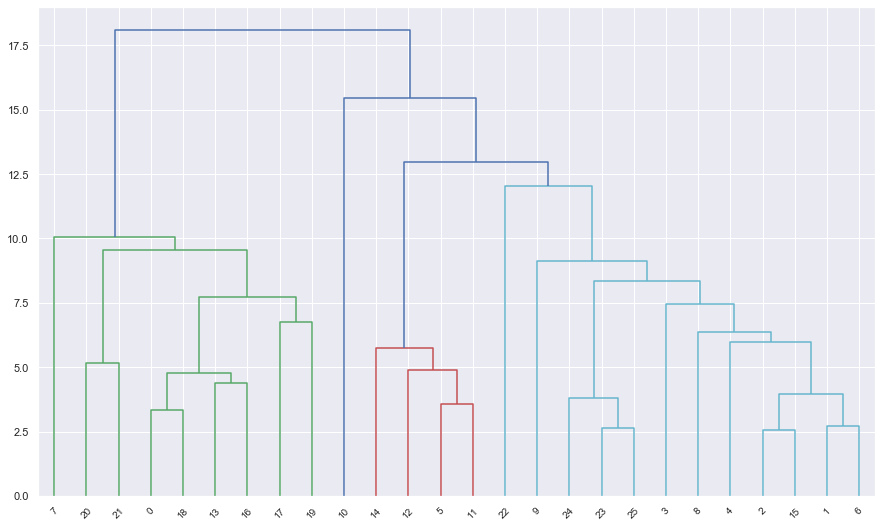

In [30]:
# Import the dendrogram function
from scipy.cluster.hierarchy import dendrogram

# Create a dendrogram
dn = dendrogram(Z)

# Display the dendogram
plt.show()

The dendrogram shows that there is most likely two large clusters (green and blue), a slightly smaller cluster (red), and a single outlying point. Let's plug in 4 clusters to our hierarchical model and take a look at a simple TiO2 vs V [tectonic discrimination diagram](https://www.researchgate.net/figure/Ti-100-vs-V-tectonic-discrimination-diagram-after-Shervais-1982-for-the-mafic-dykes_fig3_248147117).

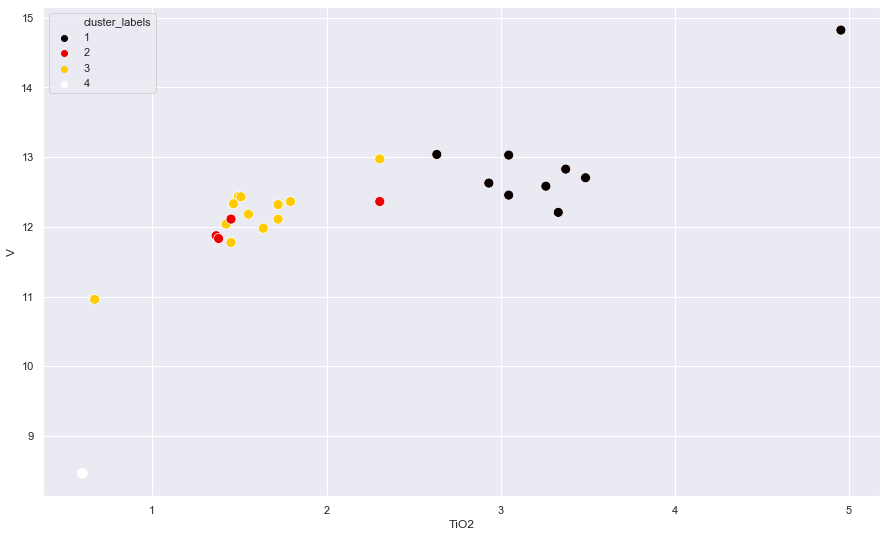

In [32]:
# Generate cluster labels
df_scaled['cluster_labels'] = fcluster(Z, 4, criterion='maxclust')

# Plot the points with seaborn
sns.scatterplot(x='TiO2', y='V', palette='hot', hue='cluster_labels', data=df_scaled, s=100)
plt.rcParams['figure.figsize']=(15,9)
plt.show()

Here we can see the four clusters returned by hierarchical clustering. There are potentially two visual clusters shown in the TiO2 vs V plot (keep in mind these elements values are still scaled) represented in black as cluster 1 and yellow as cluster 3. Cluster 1 (in red) also appears to have a few localised data points, but they're sitting within/bordering the data points in cluster 3. As expected from the dendrogram information, cluster 4 is a single outlying point.

Further investigation should be done here to determine whether these clusters are accurate, keeping in mind this is only a two dimensional visualisation of the whole dataset. But for now let's pretend we are happy with them. The next step is to add the cluster labels back to the main DataFrame.

In [33]:
#Adding the cluster labels to the original DataFrame
df['cluster_labels'] = df_scaled['cluster_labels']

<img src="Images/Dodgeball.png" />

In [34]:
# Print the size of the clusters
print(df.groupby('cluster_labels')['SAMPLE'].count())

#Seeing which sample belongs to which cluster
print(df[['SAMPLE', 'cluster_labels']])

cluster_labels
1     9
2     4
3    12
4     1
Name: SAMPLE, dtype: int64
     SAMPLE  cluster_labels
0   RA87176               1
1   RA87177               3
2   RA87178               3
3   RA87179               3
4   RA87180               3
5   RA87181               2
6   RA87182               3
7   RA87183               1
8   RA87184               3
9   RA87186               3
10  RA87187               4
11  RA87188               2
12  RA87190               2
13  RA87191               1
14  RA87192               2
15  RA87193               3
16  RA87194               1
17  RA87195               1
18  RA87196               1
19  RA87197               1
20  RA87198               1
21    THEBE               1
22    THEBE               3
23    THEBE               3
24    THEBE               3
25    THEBE               3


The clusters have been assigned to each of the samples now and we can see what group each mafic dyke belongs to. As an extra we can also have a look at the clusters mean value for each element. We can see that there are 9 samples in cluster 1, 4 in cluster 2, 12 in cluster 3 and cluster 4 contains 1 outlying data point.

In [35]:
#Print the mean value of elements in each cluster
print(df.groupby('cluster_labels').mean())

                      Al        As     Ba        Bi        Ca         Ce  \
cluster_labels                                                             
1               6.286667  9.366667  151.1  0.146667  4.387778  49.900000   
2               7.080000  2.350000  210.0  0.027500  3.047500  22.700000   
3               6.945000  3.750000  184.5  0.138333  8.701667  17.520833   
4               6.280000  4.000000  210.0  0.060000  0.570000  58.700000   

                       Co          Cr        Cs           Cu  ...        Er  \
cluster_labels                                                ...             
1               87.233333   62.444444  1.642222  1281.888889  ...  5.228889   
2               35.400000  155.250000  4.930000    87.775000  ...  2.370000   
3               41.716667  121.250000  0.350000   440.533333  ...  2.831667   
4                5.100000   48.000000  3.230000    14.900000  ...  3.710000   

                      Eu        Tb        Gd        Ho        Lu    

In conclusion, it is possible that there are 2-3 clusters in this dataset and perhaps a different clustering method could be used to return more informative results. However, given the information we have here (and the months of study) I stand by the authors original conclusion; that the geochemical assay results are not convincing enough to say there are multiple, unique sets of dyke intrusions.

For a mineral exploration example, let's say multiple geologists could not uniformly/easily assign a lithology to a granite from drill core. Instead, the general consensus was to label all granites as 'undifferentiated granite', even though it is known that there are several types of granites within the area. Given the assay data (or any other relevant data), this workflow could be used to cluster and split up those granite lithologies, paving the way to a more accurate and defined geological model. 

This notebook contains just the basics for creating unsupervised models, but I hope it sheds some more light on the capabilities and applications of machine learning in geosciences.

<img src="Images/HistoricGeo.png" />